In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.simulation import Simulation
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 160
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 5
spc = 1
l = 2

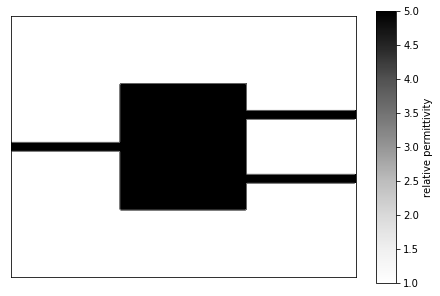

In [4]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
simulation = Simulation(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()

In [5]:
eps = simulation.eps_r
pts_in = np.sum(eps[30,:] > 1)
pts_top = np.sum(eps[Nx-30,:ny] > 1)
pts_bot = np.sum(eps[Nx-30,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))


waveguide has 5 points in in port
waveguide has 5 points in top port
waveguide has 5 points in bottom port


In [6]:
# set the modal source and probes

# simulation to solve
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 9.868405170262458 W/L0


In [7]:
# set source and solve for electromagnetic fields
print('{} grids per wavelength'.format(int(lambda0/dl/1e-6)))
(Hx,Hy,Ez) = simulation.solve_fields()

50 grids per wavelength


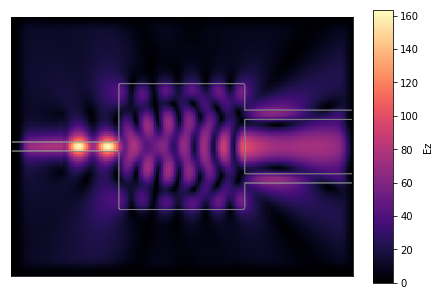

In [8]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True);

In [9]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

In [28]:
# define linear and nonlinear parts of objective function + the total objective function form
# this is an optimization like before, no eps dependence anywhere
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin
J['grad_total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: 0
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: 0

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)
kerr_nl_deps          = lambda e, eps_r:0
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps

In [29]:
simulation.eps_r = eps_r

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, dJdeps_explicit=dJdeps_explicit, eps_max=5, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, regions['design'])
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, regions, nonlin_fns)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))


1.108085857717059 1.1080861804657616 3.2274870265247557e-07
0.9066085491737104 0.9066080201591831 5.290145272951463e-07
-8.002995972942605 -8.002999820746481 3.847803876411149e-06
-22.87154346876448 -22.871569672133774 2.6203369294819367e-05
-6.996193467867464 -6.996205192990601 1.1725123137296123e-05
1.419660411641475 1.4196572374203242 3.17422115081456e-06
2.158021090244852 2.15801912418101 1.9660638419516374e-06
-2.092456292181389 -2.092458507831907 2.215650517722878e-06
5.739473922971334 5.739477674069349 3.7510980144261907e-06
-8.09543361610827 -8.095445537037449 1.1920929178899087e-05


100% (100 of 100) |######################| Elapsed Time: 0:07:58 ETA:  00:00:00

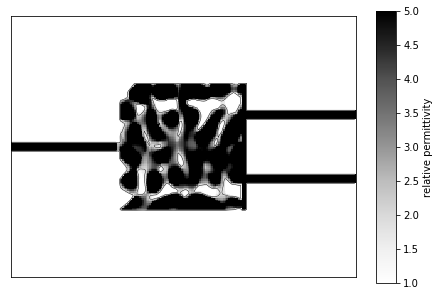

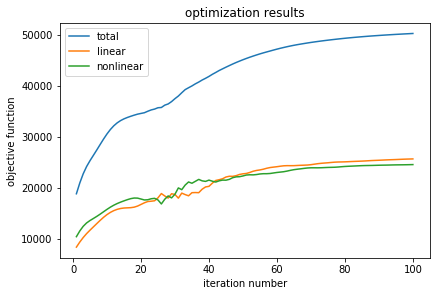

In [30]:
# run that optimization with the simulation and your objective function stuff
(new_eps_1) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

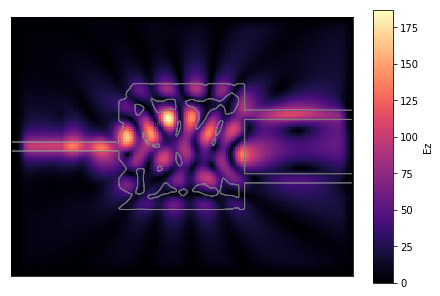

In [44]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

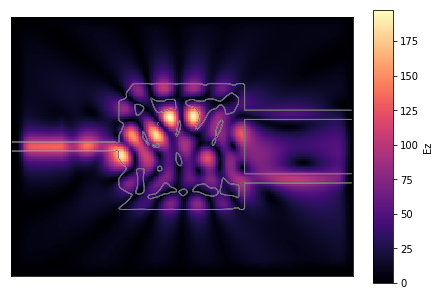

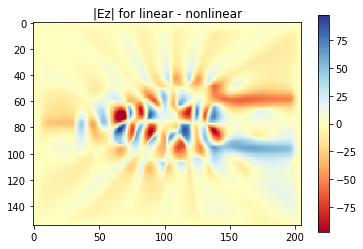

In [45]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

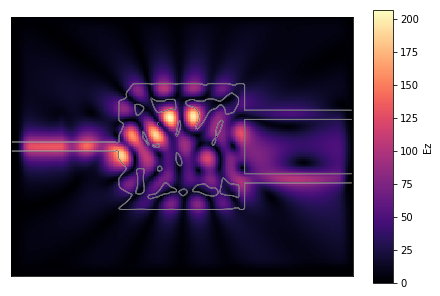

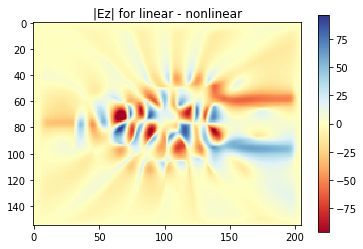

In [46]:
# compare the nonlinear and linear fields when we scale the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
nonlin_fns['eps_nl'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [10]:
# define linear and nonlinear parts of objective function + the total objective function form
# here I scale the nonlinearity by a factor that is 1 when eps_r = eps_max and 0 when eps_r = 1
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin
J['grad_total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: 0
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: 0

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
kerr_nl_deps          = lambda e, eps_r: 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*(1/(eps_max - 1))
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps

In [11]:
simulation.eps_r = eps_r

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, dJdeps_explicit=dJdeps_explicit, eps_max=5, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, regions['design'])
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, regions, nonlin_fns)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))

-3.365624861421744 -3.3656281448202208 3.283398476661148e-06
-11.863900087223135 -11.863913205161225 1.3117938090445591e-05
1.103915705924396 1.1039085256925318 7.180231864190034e-06
4.309096585754238 4.309100095269969 3.50951573047098e-06
-2.1500762224365997 -2.1500834009202663 7.178483666603341e-06
0.08441197451823002 0.08441171303275041 2.6148547960236357e-07
-13.847673368755212 -13.847684040229069 1.0671473857470914e-05
2.4314635805031855 2.431460925436113 2.6550670724212466e-06
7.634263275761617 7.634267640241887 4.364480270524496e-06
-19.04669716740321 -19.04672051750822 2.335010501042234e-05


100% (100 of 100) |######################| Elapsed Time: 0:08:05 ETA:  00:00:00

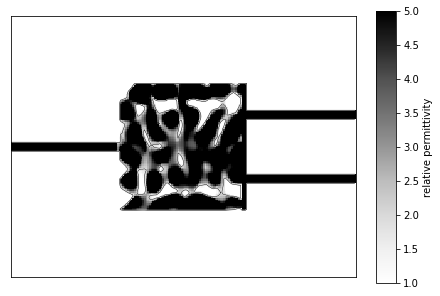

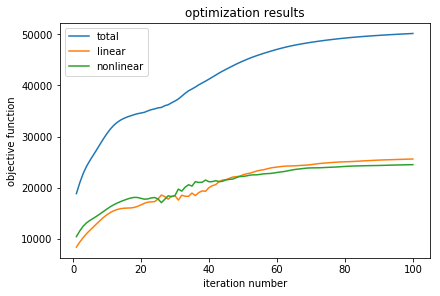

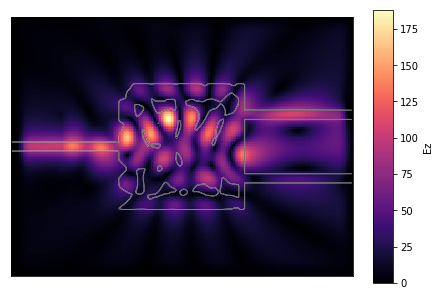

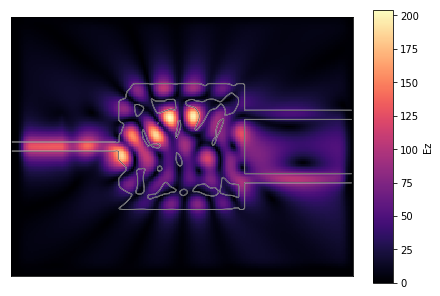

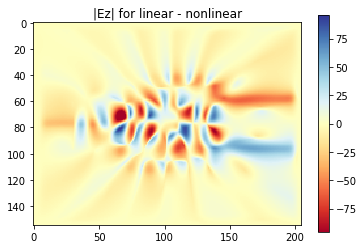

In [12]:
# run that optimization with the simulation and your objective function stuff
(new_eps) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

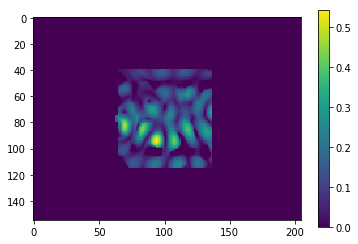

In [15]:
nshift = opt_both.compute_index_shift(simulation, regions, nonlin_fns)
plt.imshow((nshift).T)
plt.colorbar()
plt.show()

8.974090257915991


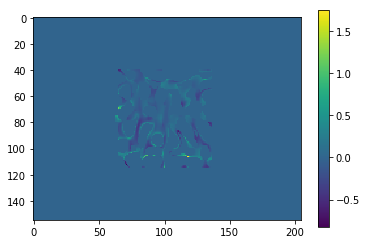

In [38]:
# There is no visible difference between this optimization and the previous one in terms of objective function,
# but they are not exactly the same
print(np.linalg.norm(new_eps - new_eps_1))
plt.imshow((new_eps - new_eps_1).T)
plt.colorbar()
plt.show()

In [77]:
# define linear and nonlinear parts of objective function + the total objective function form
# now I also include a term 1/np.sum(eps_r) in the objective function to try to force it to stay to low-eps values. 
# in the optimization, I increase eps_max
J = {}
J['linear']    =  lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)/np.sum(eps_r)
J['nonlinear'] =  lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)/np.sum(eps_r)
J['total']     =  lambda J_lin, J_nonlin: J_lin + J_nonlin
J['grad_total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top/np.sum(eps_r)
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot/np.sum(eps_r)

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: -np.sum(np.square(np.abs(e))*J_top)/np.square(np.sum(eps_r))*np.ones(eps_r.shape)
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: -np.sum(np.square(np.abs(e))*J_bot)/np.square(np.sum(eps_r))*np.ones(eps_r.shape)

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
kerr_nl_deps          = lambda e, eps_r: 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*(1/(eps_max - 1))
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps

In [80]:
simulation.eps_r = eps_r

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, dJdeps_explicit=dJdeps_explicit, eps_max=15, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, regions['design'])
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i])/np.linalg.norm(avm_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, regions, nonlin_fns)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i])/np.linalg.norm(avm_grads[i]))

-2.0586084974521684e-05 -2.058610143462758e-05 7.995743685881295e-07
0.0002654245287829269 0.00026542466446954904 5.11206039512255e-07
-9.153097355521367e-05 -9.153114738369439e-05 1.8991219470827e-06
-5.5590545098544164e-05 -5.5590586300890976e-05 7.411754415943025e-07
9.504802906976644e-05 9.504805803528527e-05 3.0474612792850503e-07
-9.624468661862384e-05 -9.624474245351067e-05 5.801347460553817e-07
5.878366184509246e-05 5.8783633238856936e-05 4.866358206718322e-07
-0.0002342968258017476 -0.0002342970789603882 1.0805039280842405e-06
-0.0001431320562007464 -0.0001431322407818847 1.2895862967146093e-06
-0.00016703814915204547 -0.00016703824934349853 5.998118008981209e-07


100% (100 of 100) |######################| Elapsed Time: 0:10:34 ETA:  00:00:00

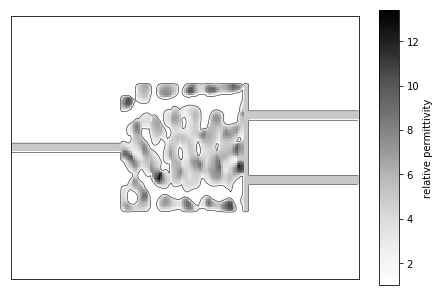

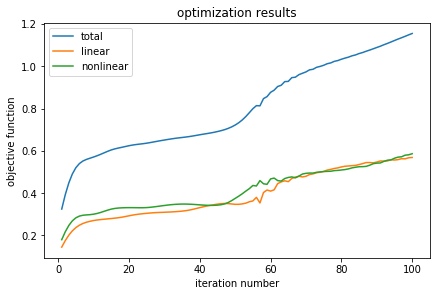

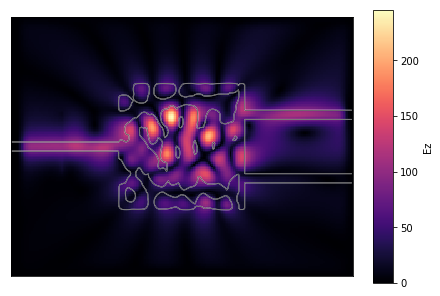

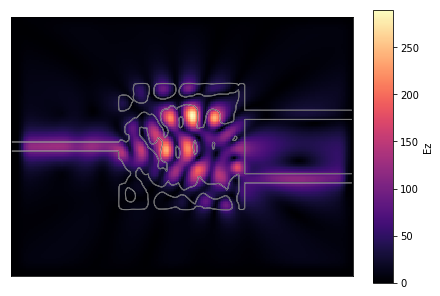

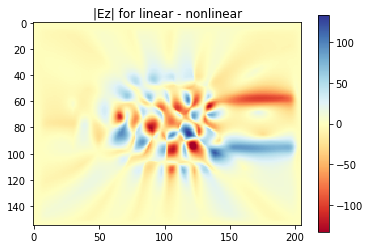

In [81]:
# run that optimization with the simulation and your objective function stuff
(new_eps) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [82]:
# for completeness let's see what we get without the eps_r term
J = {}
J['linear']    =  lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] =  lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     =  lambda J_lin, J_nonlin: J_lin + J_nonlin
J['grad_total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: 0
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: 0

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
kerr_nl_deps          = lambda e, eps_r: 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*(1/(eps_max - 1))
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps

100% (100 of 100) |######################| Elapsed Time: 0:12:33 ETA:  00:00:00

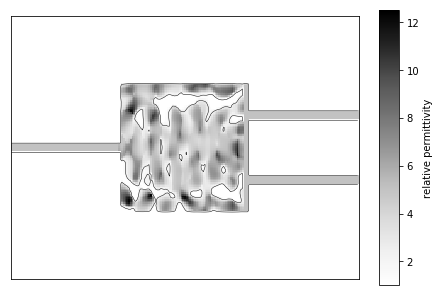

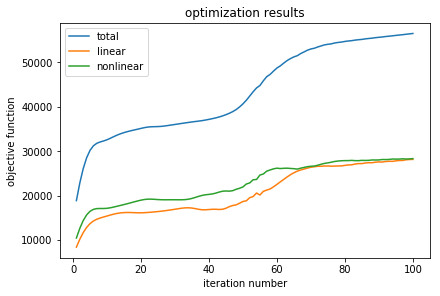

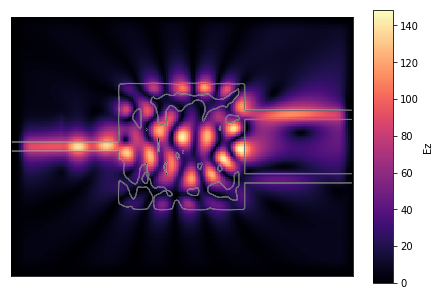

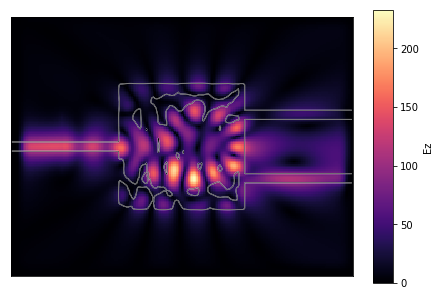

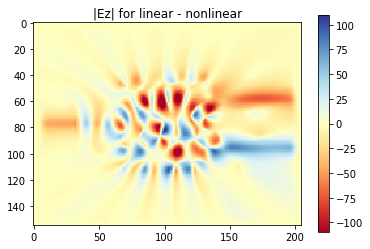

In [84]:
simulation.eps_r = eps_r

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, dJdeps_explicit=dJdeps_explicit, eps_max=15, step_size=.1, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()